In [1]:
import pandas as pd
import numpy as np
import pandas_datareader as wb
import matplotlib.pyplot as plt


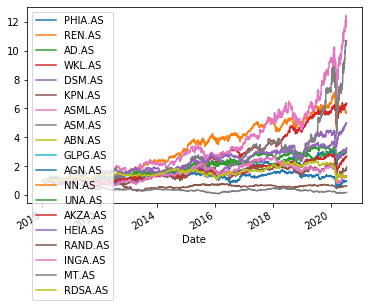

In [11]:
# List stocks or indices to download
tickers = ['PHIA.AS', 'REN.AS', 'AD.AS', 'WKL.AS', 'DSM.AS',
'KPN.AS', 'ASML.AS', 'ASM.AS', 'ABN.AS', 'GLPG.AS', 'AGN.AS',
'NN.AS', 'UNA.AS', 'AKZA.AS', 'HEIA.AS', 'RAND.AS', 'INGA.AS',
'MT.AS', 'RDSA.AS',  
]

# Request tickers data
df = wb.DataReader(tickers, 'yahoo', '2010-01-01')

# Plot normalised returns
(df['Adj Close'] / df['Adj Close'].iloc[0]).plot()
plt.legend(loc=2)
plt.show()

# Fix datetime index
df.index = pd.DatetimeIndex(df.index).to_period('M')

In [3]:
# Feature engineering

for tick in tickers:
    # Return column
    df['Returns', tick] = np.log(df['Adj Close', tick] / df['Adj Close', tick].shift(1))

    # 1-5 day lags
    df['1_day_lag', tick] = df['Returns', tick].shift(1)
    df['2_day_lag', tick] = df['Returns', tick].shift(2)
    df['3_day_lag', tick] = df['Returns', tick].shift(3)
    df['4_day_lag', tick] = df['Returns', tick].shift(4)
    df['5_day_lag', tick] = df['Returns', tick].shift(5)

    #High-Low spread
    df['HL_spread', tick] = (df['High', tick] - df['Low', tick]) / df['Close', tick]
    df['HL_lag_1', tick] = df['HL_spread', tick].shift(1)
    df['HL_lag_2', tick] = df['HL_spread', tick].shift(2)
    df['HL_lag_3', tick] = df['HL_spread', tick].shift(3)
    df.drop('HL_spread', axis=1, inplace=True)

    # Categorical return (1 if > 0 and 0 otherwise)
    df['Cat_return', tick] = np.multiply(df['Returns', tick] > 0, 1)

# Drop nan's 
df.dropna(axis=0, inplace=True)

#df = df.stack()

print('Number of trading days (rows): ', df.shape[0])

df.tail()


Number of trading days (rows):  1184


Attributes  Adj Close                                                      \
Symbols       PHIA.AS     REN.AS      AD.AS     WKL.AS      DSM.AS KPN.AS   
Date                                                                        
2020-07     42.509998  19.670000  24.930000  69.720001  128.000000  2.421   
2020-07     44.419998  20.059999  25.100000  70.379997  128.750000  2.426   
2020-07     43.415001  19.855000  25.190001  71.040001  128.350006  2.448   
2020-07     43.430000  19.844999  25.219999  70.900002  128.649994  2.441   
2020-07     45.814999  19.754999  25.389999  71.360001  129.949997  2.470   

Attributes                                            ...   Returns 1_day_lag  \
Symbols        ASML.AS      ASM.AS ABN.AS      NN.AS  ...   RAND.AS   RAND.AS   
Date                                                  ...                       
2020-07     343.299988  144.399994  8.210  32.900002  ... -0.007680  0.024687   
2020-07     330.700012  144.050003  8.348  32.930000  ...  0.019325 -0.007680   
2020-07     331.700012  144.699997  8.452  32.790001  ... -0.007352  0.019325   
2020-07     333.100006  145.500000  8.396  32.520000  ... -0.027511 -0.007352   
2020-07     342.399994  147.850006  8.324  32.950001  ...  0.111264 -0.027511   

Attributes 2_day_lag 3_day_lag 4_day_lag 5_day_lag  HL_lag_1  HL_lag_2  \
Symbols      RAND.AS   RAND.AS   RAND.AS   RAND.AS   RAND.AS   RAND.AS   
Date                                                                     
2020-07     0.017800 -0.008198 -0.016683  0.000974  0.021516  0.035531   
2020-07     0.024687  0.017800 -0.008198 -0.016683  0.016141  0.021516   
2020-07    -0.007680  0.024687  0.017800 -0.008198  0.020085  0.016141   
2020-07     0.019325 -0.007680  0.024687  0.017800  0.022614  0.020085   
2020-07    -0.007352  0.019325 -0.007680  0.024687  0.033032  0.022614   

Attributes  HL_lag_3 Cat_return  
Symbols      RAND.AS    RAND.AS  
Date                             
2020-07     0.028685          0  
2020-07     0.035531          1  
2020-07     0.021516          0  
2020-07     0.016141          0  
2020-07     0.020085          1  

[5 rows x 304 columns]

In [7]:
df['Returns']

KeyError: 1

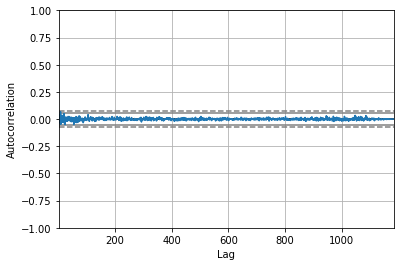

ValueError: x is required to have ndim 1 but has ndim 2

In [4]:
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf

# Autocorrelation
autocorrelation_plot(df['Returns'])
plt.show()

# Partial autocorrelation
plot_pacf(df['Returns'])
plt.show()

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
pd.plotting.register_matplotlib_converters()

model = ARIMA(df['Returns'], order=(2, 0, 0))
results = model.fit(disp=-1)

df['Returns'].plot()
plt.plot(results.fittedvalues, color='red')
plt.show()

In [257]:
doekoe = 100_000
cost = 1 

#for i in range(-5, 5, 1):
rets = []
num_trade = 0

zipper = zip(df['Returns']['RDSA.AS'], results.fittedvalues.shift(2))

for ret, pred in zipper:
    if pred > 0:
        doekoe = (1 + ret) * doekoe - cost
        rets.append(ret)
        num_trade += 1

#print('prediction shift: ', i)
print(round(doekoe), 'Euro')
print(num_trade) 
print(' ')  

88550 Euro
1385
 


In [23]:
X = df[['1_day_lag', '2_day_lag', '3_day_lag',
        '4_day_lag', '5_day_lag', 
        #'HL_lag_1', 'HL_lag_2','HL_lag_3'
        ]]
y = df['Adj Close']
y_cat = df['Cat_return']

df_len = X.shape[0]
test_size = 0.2 

X_test = X.tail(int(df_len * test_size))
X_train = X.head(int(df_len * (1 - test_size)))

y_test = y.tail(int(df_len * test_size))
y_train = y.head(int(df_len * (1 - test_size)))

y_cat_test = y_cat.tail(int(df_len * test_size))
y_cat_train = y_cat.head(int(df_len * (1 - test_size)))


In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

#instantiate linear model
lm = LinearRegression()

#fit the model to the training set
lm.fit(X_train, y_train)

#predict using the test set and training set
pred_test = lm.predict(X_test)

#score the two predictions above
score_test = r2_score(y_test, pred_test)

#create a new table with coefficiencts found by the model
coefs = pd.DataFrame()
coefs['feature'] = X.columns
coefs['coefficient'] = lm.coef_
coefs['absolute coef'] = np.abs(lm.coef_)

#sort the coefficients from large to small and add an extra row with the intercept at 
#the bottom of the table
coefs = coefs.sort_values('absolute coef', ascending=False)
coefs = coefs.append({'feature':'Intercept', 'coefficient':lm.intercept_, \
                      'absolute coef':np.abs(lm.intercept_)}, ignore_index=True)

print(coefs, end='\n\n')

lm_error = np.mean(abs(pred_test - y_test))

print("Average error:", round(lm_error, 3))
print("R2-score of the model on the test data:", round(score_test,3))

feature  coefficient  absolute coef
0  4_day_lag     0.606259       0.606259
1  3_day_lag     0.568673       0.568673
2  2_day_lag     0.545374       0.545374
3  5_day_lag     0.476316       0.476316
4  1_day_lag     0.470785       0.470785
5  Intercept     1.414895       1.414895

Average error: 0.165
R2-score of the model on the test data: -0.248


In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

#instantiate the Random Forest regressor
rf = RandomForestRegressor(n_estimators = 1000, n_jobs=2)

#fit the model to the training set
rf.fit(X_train, y_train)

#predict on the test set
rf_preds = rf.predict(X_test)

#score the prediction
rf_r2_score = r2_score(y_test, rf_preds)

#calculate average error between prediction and known y-value
rf_error = np.mean(abs(rf_preds - y_test))

#print results
print("Average error:", round(rf_error, 3))
print("R2-score of the model on the test data:", round(rf_r2_score,3))

Average error: 0.172
R2-score of the model on the test data: -0.157


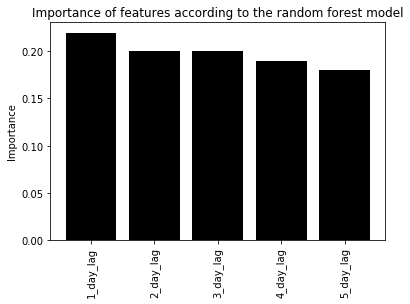

In [17]:
importance = list(rf.feature_importances_.round(2))
importance.sort(reverse=True)
features = list(X.columns)

x_values = np.array(list(range(len(importance))))
plt.bar(features, importance, color='black')
plt.xticks(rotation='vertical')
plt.ylabel('Importance')
plt.title('Importance of features according to the random forest model')
plt.show()

In [11]:
from sklearn.svm import SVC

clf = SVC(gamma='scale')
clf.fit(X_train, y_cat_train)
svc_pred = clf.predict(X_test)

print('Accuracy: ' + str(int((y_cat_test== svc_pred).sum() / len(y_cat_test) * 100)) + '%')

Accuracy: 52%


In [12]:
# Baseline prediction which assumes positive returns every day
all_one = [1] * len(y_cat_test)
print('Accuracy: ' + str(int((y_cat_test == all_one).sum() / len(y_cat_test) * 100)) + '%')

Accuracy: 49%


In [13]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=1000, n_jobs=2)
clf_rf.fit(X_train, y_cat_train)

clf_rf_pred = clf_rf.predict(X_test)

print('Accuracy: ' + str(int((y_cat_test == clf_rf_pred).sum() / len(y_cat_test) * 100)) + '%')

Accuracy: 51%


In [191]:
high_vol_df = df.reset_index(level=['Date', 'Symbols'])
high_vol_days = list()

for idx, ret in enumerate(high_vol_df['1_day_lag']):
    if abs(ret) > 0.02:
        high_vol_days.append(idx)

high_vol_df = high_vol_df[high_vol_df.index.isin(high_vol_days)]
high_vol_df.head()

In [149]:
'''
New dependent and independent variables with high volatility
'''

X = high_vol_df[['1_day_lag', '2_day_lag', '3_day_lag',
        #'4_day_lag', '5_day_lag', 
        'HL_lag_1', 'HL_lag_2','HL_lag_3']]
y = high_vol_df['Returns']
y_cat = high_vol_df['Cat_return']

df_len = X.shape[0]
test_size = 0.2 

X_test = X.tail(int(df_len * test_size))
X_train = X.head(int(df_len * (1 - test_size)))

y_test = y.tail(int(df_len * test_size))
y_train = y.head(int(df_len * (1 - test_size)))

y_cat_test = y_cat.tail(int(df_len * test_size))
y_cat_train = y_cat.head(int(df_len * (1 - test_size)))

print(len(y_test))

461


In [124]:
df['Returns']['DPA.AS']  results.fittedvalues

Date
2010-01    0.028566
2010-01    0.044536
2010-01    0.078033
2010-01   -0.017101
2010-01    0.003064
             ...   
2020-07    0.055063
2020-07    0.019169
2020-07    0.004562
2020-07   -0.017744
2020-07    0.002653
Freq: M, Length: 57238, dtype: float64

In [44]:
transactie_kosten = 2

buy_n_hold_total = 0
strat_total = 0 

starting_capital = 1000_00

for tick in tickers:
    doekoe = starting_capital
    num_trade = 0

    zipper = zip(df['Returns'][tick], df['1_day_lag'][tick])

    for ret, lag in zipper:
        # Long
        if lag > 0:
            doekoe = (1 + ret) * doekoe - transactie_kosten
            num_trade += 1
        # Short
        elif lag < 0:
            doekoe = (1 - ret) * doekoe - transactie_kosten
            num_trade += 1    

    strat_total += doekoe
    buy_n_hold = df['Adj Close'][tick].iloc[-1] / df['Adj Close'][tick].iloc[0] * starting_capital
    buy_n_hold_total += buy_n_hold

    print(tick)
    print(int(buy_n_hold), 
    'Euro als je buy en hold had gedaan')
    print(int(doekoe), 'Euro volgens onze strategie')
    print('in', num_trade, 'Trades', end='\n\n')  

PHIA.AS
209846 Euro als je buy en hold had gedaan
235186 Euro volgens onze strategie
in 1175 Trades

REN.AS
135280 Euro als je buy en hold had gedaan
31398 Euro volgens onze strategie
in 1168 Trades

AD.AS
134437 Euro als je buy en hold had gedaan
120496 Euro volgens onze strategie
in 1168 Trades

WKL.AS
239306 Euro als je buy en hold had gedaan
114301 Euro volgens onze strategie
in 1170 Trades

DSM.AS
301047 Euro als je buy en hold had gedaan
94796 Euro volgens onze strategie
in 1172 Trades

KPN.AS
82796 Euro als je buy en hold had gedaan
30121 Euro volgens onze strategie
in 1163 Trades

ASML.AS
401083 Euro als je buy en hold had gedaan
119771 Euro volgens onze strategie
in 1173 Trades

ASM.AS
456323 Euro als je buy en hold had gedaan
25093 Euro volgens onze strategie
in 1174 Trades

ABN.AS
59945 Euro als je buy en hold had gedaan
115153 Euro volgens onze strategie
in 1172 Trades

NN.AS
128442 Euro als je buy en hold had gedaan
67050 Euro volgens onze strategie
in 1172 Trades

UNA.AS


In [45]:
total_start_cap = len(tickers) * starting_capital
print('Buy n hold winst:', int(buy_n_hold_total) - total_start_cap, 'Euro')
print('Strat winst:', int(strat_total) - total_start_cap, 'Euro')

Buy n hold winst: 1450823 Euro
Strat winst: 576546 Euro


In [24]:
len(tickers) * starting_capital

19000000